In [ ]:
# Step 1: libraries
!pip install -q tensorflow keras pandas matplotlib opencv-python scikit-learn

import os, glob, subprocess, json, random, math, shutil, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: mount Drive so outputs persist
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Workspace
BASE  = "/content/drive/MyDrive/nutrition5k_project"
DATA  = f"{BASE}/data"
IMAG  = f"{DATA}/imagery"
META  = f"{DATA}/metadata"
SCRIP = f"{DATA}/scripts"
SUBSA = f"{IMAG}/side_angles"

for d in [BASE, DATA, IMAG, META, SCRIP, SUBSA]:
    os.makedirs(d, exist_ok=True)

print("Folders ready:", BASE)


Mounted at /content/drive
Folders ready: /content/drive/MyDrive/nutrition5k_project


In [ ]:
# Step 2a: metadata (small)
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/metadata/*" "$META/"
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits" "$DATA/"
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/scripts/*" "$SCRIP/"
!ls -la "$META"


Copying gs://nutrition5k_dataset/nutrition5k_dataset/metadata/ingredients_metadata.csv...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe2.csv...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe1.csv...
/ [3/3 files][  2.2 MiB/  2.2 MiB] 100% Done                                    
Operation completed over 3 objects/2.2 MiB.                                      
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/rgb_test_ids.txt...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/depth_train_ids.txt...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/depth_test_ids.txt...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/rgb_train_ids.txt...
/ [4/4 files][125.5 KiB/125.5 KiB] 100% Done                                    
Operation completed over 4 objects/125.5 KiB.                                    
Copying gs://nutrition5k_dataset/nutrition5k

In [ ]:
# Step 2b: side-angle videos — small subset (first 20 dish folders)
BUCKET = "gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles"
!mkdir -p "$SUBSA"

# list first 20 dish folders via gsutil, then copy them with Python loop
dish_list = subprocess.check_output(f'gsutil ls {BUCKET} | head -n 20', shell=True)\
                      .decode().strip().split('\n')
len(dish_list), dish_list[:3]


(20,
 ['gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/dish_1550704750/',
  'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/dish_1550704903/',
  'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/dish_1550705288/'])

In [ ]:
# Step 2c: copy each selected dish folder down
for dish_uri in dish_list:
    if dish_uri.strip():
        print("Copying:", dish_uri)
        !gsutil -m cp -r "$dish_uri" "$SUBSA/"
print("Done.")


Copying: gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/dish_1550704750/
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/dish_1550704750/camera_D.h264...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/dish_1550704750/camera_B.h264...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/dish_1550704750/camera_C.h264...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/dish_1550704750/camera_A.h264...
- [4/4 files][ 76.3 MiB/ 76.3 MiB] 100% Done                                    
Operation completed over 4 objects/76.3 MiB.                                     
Copying: gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/dish_1550704903/
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/dish_1550704903/camera_D.h264...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/dish_1550704903/camera_C.h264...
Copying gs://nutrit

In [ ]:
# Step 3: extract JPEG frames with ffmpeg (fallback-friendly)
import os, glob

videos = glob.glob(f"{SUBSA}/dish_*/camera_*.h264")
print("Videos found:", len(videos))

for vid in videos:
    outdir = os.path.join(os.path.dirname(vid), "frames")
    os.makedirs(outdir, exist_ok=True)
    # every 10th frame -> JPEGs
    !ffmpeg -y -loglevel error -i "{vid}" -vf "select='not(mod(n\,10))'" -vsync vfr "{outdir}/frame_%06d.jpg"

# quick check
sum(len(glob.glob(os.path.join(p, "frames", "*.jpg"))) for p in glob.glob(f"{SUBSA}/dish_*"))


Videos found: 80
[h264 @ 0x5b82bf7e0500] error while decoding MB 118 53, bytestream -20
[h264 @ 0x58183a932fc0] error while decoding MB 57 61, bytestream -14
[h264 @ 0x5c64f4275b00] error while decoding MB 12 60, bytestream -12
[h264 @ 0x5a949a2adb00] error while decoding MB 84 62, bytestream -8
[h264 @ 0x563706fe25c0] error while decoding MB 114 54, bytestream -20
[h264 @ 0x5ac23b956f00] error while decoding MB 16 59, bytestream -8
[h264 @ 0x5918cacf8b00] error while decoding MB 82 66, bytestream -16
[h264 @ 0x5c157681d080] error while decoding MB 26 37, bytestream -14
[h264 @ 0x5a0e08b38940] error while decoding MB 82 61, bytestream -16


301

In [ ]:
# Step 4a: load dish metadata (two cafe CSVs), tolerant to malformed lines
dish_paths = sorted(glob.glob(f"{META}/dish_metadata_*.csv"))
read_opts  = dict(engine="python", sep=",", quotechar='"', escapechar="\\", on_bad_lines="skip")
dish_df    = pd.concat([pd.read_csv(p, **read_opts) for p in dish_paths], ignore_index=True)

# normalize column names (lowercase + underscores)
dish_df.columns = (dish_df.columns
                   .str.strip()
                   .str.lower()
                   .str.replace(r"[^a-z0-9]+", "_", regex=True))

print("dish_df:", dish_df.shape)
dish_df.head(2)


dish_df: (4581, 177)


,dish_1561662216,300_794281,193_000000,12_387489,28_218290,18_633970,ingr_0000000508,soy_sauce,3_398568,1_80124104,...,0_57058,0_171174,0_2168204,ingr_0000000531,pumpkin_seeds,0_684788,3_05415448,0_13010972,0_36978552,0_13010972_1
0,dish_1562688426,137.569992,88.0,8.256000,5.190000,10.297000,ingr_0000000433,roasted potatoes,17.000000,23.970000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Inspect columns to understand what's inside
print(len(dish_df.columns), "columns")
print(dish_df.columns.tolist()[:50])  # first 50 names
dish_df.head(2)


177 columns
['dish_1561662216', '300_794281', '193_000000', '12_387489', '28_218290', '18_633970', 'ingr_0000000508', 'soy_sauce', '3_398568', '1_80124104', '0_020391408', '0_166529832', '0_275284008', 'ingr_0000000122', 'garlic', '2_124105', '3_16491645', '0_010620525', '0_70095465', '0_13594272', 'ingr_0000000026', 'white_rice', '8_496420', '11_045346', '0_02548926', '2_3789976', '0_22940334', 'ingr_0000000524', 'parsley', '0_213397', '0_079170287', '0_001707176', '0_013657408', '0_006188513', 'ingr_0000000094', 'onions', '1_707173', '0_6828692', '0_001707173', '0_15364557', '0_018778903', 'ingr_0000000023', 'brown_rice', '68_000000', '75_48', '0_612', '15_64', '1_768', 'ingr_0000000189', 'vinegar']


,dish_1561662216,300_794281,193_000000,12_387489,28_218290,18_633970,ingr_0000000508,soy_sauce,3_398568,1_80124104,...,0_57058,0_171174,0_2168204,ingr_0000000531,pumpkin_seeds,0_684788,3_05415448,0_13010972,0_36978552,0_13010972_1
0,dish_1562688426,137.569992,88.0,8.256000,5.190000,10.297000,ingr_0000000433,roasted potatoes,17.000000,23.970000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import os, glob, re
from pathlib import Path

# dish folder names like 'dish_1561662216'
dish_folders = [Path(p).name for p in glob.glob(f"{SUBSA}/dish_*")]
print("Folders found:", len(dish_folders))
dish_folders[:5]

# numeric part as well (e.g., '1561662216')
folder_nums = [re.sub(r"^dish_", "", d) for d in dish_folders]
folder_set  = set(dish_folders)
num_set     = set(folder_nums)


Folders found: 20


In [ ]:
import pandas as pd

def coverage_score(series: pd.Series):
    s = series.astype(str).str.strip()
    # try exact matches with 'dish_*'
    exact = s.isin(folder_set).sum()
    # try numeric-only matches (strip non-digits)
    nums  = s.str.replace(r"\D","", regex=True)
    num_match = nums.isin(num_set).sum()
    return exact, num_match, max(exact, num_match)

scores = []
for col in dish_df.columns:
    e, n, m = coverage_score(dish_df[col])
    if m > 0:
        scores.append((m, e, n, col))

# Sort by best coverage
scores_sorted = sorted(scores, reverse=True)
scores_sorted[:10]


[(np.int64(20), np.int64(20), np.int64(20), 'dish_1561662216')]

In [ ]:
assert len(scores_sorted) > 0, "Could not find any column that overlaps with dish folder IDs."

best_m, best_e, best_n, best_col = scores_sorted[0]
print(f"Selected ID column: {best_col}  | matches={best_m} (exact={best_e}, numeric={best_n})")

dish_df = dish_df.copy()

# Make a canonical 'dish_id' that matches folder names like 'dish_12345'
col_as_str = dish_df[best_col].astype(str).str.strip()
if best_e >= best_n:
    # Values already look like 'dish_123...'
    dish_df["dish_id"] = col_as_str
else:
    # Values are numeric; prefix 'dish_'
    dish_df["dish_id"] = "dish_" + col_as_str.str.replace(r"\D","", regex=True)

# Final tidy
dish_df["dish_id"] = dish_df["dish_id"].astype(str)
print(dish_df["dish_id"].head(5).tolist())


Selected ID column: dish_1561662216  | matches=20 (exact=20, numeric=20)
['dish_1562688426', 'dish_1561662054', 'dish_1562008979', 'dish_1560455030', 'dish_1558372433']


In [ ]:
# Show any columns that look like macros (case-insensitive)
def show_matches(kw):
    m = [c for c in dish_df.columns if kw.lower() in c.lower()]
    print(f"{kw}: {len(m)} matches")
    print(m[:30])  # first 30

show_matches("protein")
show_matches("carb")
show_matches("fat")
show_matches("lipid")
show_matches("kcal")
show_matches("energy")



protein: 0 matches
[]
carb: 0 matches
[]
fat: 0 matches
[]
lipid: 0 matches
[]
kcal: 0 matches
[]
energy: 0 matches
[]


In [ ]:
rename_map = {
    "protein_g": "total_protein",
    "carbohydrates": "total_carb",
    "fat_g": "total_fat",
    "energy_kcal": "total_calories",  # if you want to standardize calories too
}
present = {k:v for k,v in rename_map.items() if k in dish_df.columns}
dish_df = dish_df.rename(columns=present)


In [ ]:
import re
import numpy as np
import pandas as pd

# 2A) Build a sanitized alias for each column (letters only) to make matching easier
def sanitize(s: str) -> str:
    return re.sub(r'[^a-z]', '', s.lower())

aliases = {c: sanitize(c) for c in dish_df.columns}

def best_numeric(df: pd.DataFrame, name_keys, min_nonnull=50):
    """
    Find the 'best' numeric column whose sanitized name contains any token in name_keys.
    Criteria: numeric dtype, name match, reasonable non-null count, reasonable value range.
    """
    candidates = []
    for col in df.columns:
        ali = aliases[col]
        if any(k in ali for k in name_keys):
            s = df[col]
            if pd.api.types.is_numeric_dtype(s):
                nonnull = s.notna().sum()
                if nonnull >= min_nonnull:
                    # Heuristic: grams should usually be between 0 and ~300 per dish
                    q95 = np.nanpercentile(s.astype(float), 95)
                    q05 = np.nanpercentile(s.astype(float), 5)
                    spread = q95 - q05
                    candidates.append((nonnull, -spread, col))  # prefer more coverage, tighter spread
    if not candidates:
        return None
    # pick best: max non-null, then tighter spread
    candidates.sort(reverse=True)
    return candidates[0][2]

# 2B) Try to detect each macro
prot_col = best_numeric(dish_df, ["protein", "proteins", "prot"])
carb_col = best_numeric(dish_df, ["carb", "carbohydrate", "carbohydrates", "starch"])
fat_col  = best_numeric(dish_df, ["fat", "fats", "lipid"])

# calories: prefer kcal/energy columns
def best_cal(df):
    # first, exact-ish names
    for k in ["energykcal","kcal","calories","caloriestotal"]:
        for col, ali in aliases.items():
            if k in ali and pd.api.types.is_numeric_dtype(df[col]):
                return col
    # fallback: any 'energy' numeric column with large range
    cand = best_numeric(df, ["energy"])
    return cand

cal_col = best_cal(dish_df)

found_cols = {
    "total_calories": cal_col,
    "total_protein":  prot_col,
    "total_carb":     carb_col,
    "total_fat":      fat_col,
}
print("Detected:", found_cols)
missing = [k for k,v in found_cols.items() if v is None]
if missing:
    print("Missing:", missing, "— try Step 1 output to identify exact column names and add them to the manual rename_map.")


Detected: {'total_calories': None, 'total_protein': None, 'total_carb': None, 'total_fat': None}
Missing: ['total_calories', 'total_protein', 'total_carb', 'total_fat'] — try Step 1 output to identify exact column names and add them to the manual rename_map.


In [ ]:
# Show first 60 column names
print(len(dish_df.columns), "columns total")
for i, c in enumerate(dish_df.columns[:60], start=1):
    print(i, c)



178 columns total
1 dish_1561662216
2 300_794281
3 193_000000
4 12_387489
5 28_218290
6 18_633970
7 ingr_0000000508
8 soy_sauce
9 3_398568
10 1_80124104
11 0_020391408
12 0_166529832
13 0_275284008
14 ingr_0000000122
15 garlic
16 2_124105
17 3_16491645
18 0_010620525
19 0_70095465
20 0_13594272
21 ingr_0000000026
22 white_rice
23 8_496420
24 11_045346
25 0_02548926
26 2_3789976
27 0_22940334
28 ingr_0000000524
29 parsley
30 0_213397
31 0_079170287
32 0_001707176
33 0_013657408
34 0_006188513
35 ingr_0000000094
36 onions
37 1_707173
38 0_6828692
39 0_001707173
40 0_15364557
41 0_018778903
42 ingr_0000000023
43 brown_rice
44 68_000000
45 75_48
46 0_612
47 15_64
48 1_768
49 ingr_0000000189
50 vinegar
51 0_853586
52 0_0
53 0_0_1
54 0_0_2
55 0_0_3
56 ingr_0000000054
57 apple
58 4_267931
59 2_21932412
60 0_008535862


In [ ]:
# Search by possible nutrition keywords
keywords = ["cal", "ener", "kcal", "protein", "prot", "carb", "fat", "lipid"]
for kw in keywords:
    matches = [c for c in dish_df.columns if kw.lower() in c.lower()]
    print(f"{kw}: {matches}")


cal: []
ener: []
kcal: []
protein: []
prot: []
carb: []
fat: []
lipid: []


In [ ]:
# Step 4D-1 — load ingredient metadata and show columns
import pandas as pd, glob, re, numpy as np

ing_candidates = sorted(glob.glob(f"{META}/ingredient*.csv"))
assert len(ing_candidates) > 0, "ingredient_metadata.csv not found in META. Re-run the gsutil copy for metadata."
ing_csv = ing_candidates[0]
print("Using ingredient CSV:", ing_csv)

read_opts = dict(engine="python", sep=",", quotechar='"', escapechar="\\", on_bad_lines="skip")
ing_df = pd.read_csv(ing_csv, **read_opts)

# normalize column names
ing_df.columns = (ing_df.columns
                  .str.strip()
                  .str.lower()
                  .str.replace(r"[^a-z0-9]+","_", regex=True))

print("Ingredient columns (first 60):")
print(list(ing_df.columns)[:60])
print("Rows:", len(ing_df))


Using ingredient CSV: /content/drive/MyDrive/nutrition5k_project/data/metadata/ingredients_metadata.csv
Ingredient columns (first 60):
['ingr', 'id', 'cal_g', 'fat_g_', 'carb_g_', 'protein_g_']
Rows: 555


In [ ]:
# 4D — robust ingredient metadata loader (with Atwater fallback for calories)
import pandas as pd, glob, re, numpy as np

ing_candidates = sorted(glob.glob(f"{META}/ingredient*.csv"))
assert len(ing_candidates) > 0, "ingredient_metadata.csv not found in META."
ing_csv = ing_candidates[0]
print("Using ingredient CSV:", ing_csv)

read_opts = dict(engine="python", sep=",", quotechar='"', escapechar="\\", on_bad_lines="skip")
ing_df = pd.read_csv(ing_csv, **read_opts)

# Normalize columns
ing_df.columns = (ing_df.columns
                  .str.strip()
                  .str.lower()
                  .str.replace(r"[^a-z0-9]+","_", regex=True))

print("First 50 ingredient columns:\n", ing_df.columns.tolist()[:50])

# --- detect id col ---
id_col = None
for c in ["ingredient_id","ingr_id","ing_id","id","ingredientid","idx"]:
    if c in ing_df.columns:
        id_col = c; break
assert id_col is not None, f"Couldn't find ingredient id column. Columns: {ing_df.columns.tolist()}"

# --- detect macro columns (g per 100g typically) ---
def pick_first(df, aliases, fuzzy=None):
    for a in aliases:
        if a in df.columns: return a
    if fuzzy:
        for col in df.columns:
            if any(k in col for k in fuzzy): return col
    return None

pro_col = pick_first(ing_df, ["protein_g_per_100g","protein_per_100g","protein_g","protein"], fuzzy=["protein","prot"])
carb_col = pick_first(ing_df, ["carbohydrate_g_per_100g","carbs_g_per_100g","carbohydrates","carbohydrate","carbs"], fuzzy=["carb","carbo"])
fat_col  = pick_first(ing_df, ["fat_g_per_100g","fat_per_100g","fat_g","fat"], fuzzy=["fat","lipid"])

assert pro_col is not None, "No protein column found in ingredient metadata."
assert carb_col is not None, "No carbohydrate column found in ingredient metadata."
assert fat_col  is not None, "No fat column found in ingredient metadata."

# --- detect energy (kcal/kJ); if missing, compute via Atwater ---
cal_kcal = pick_first(ing_df, ["calories_per_100g","calories_kcal_per_100g","kcal_per_100g","energy_kcal_per_100g","energy_kcal","kcal"], fuzzy=["kcal","calor","energy_kcal"])
cal_kj   = pick_first(ing_df, ["energy_kj_per_100g","kj_per_100g","energy_kj","kilojoules"], fuzzy=["_kj","kj"])

if cal_kcal is None and cal_kj is None:
    # Atwater fallback (assume g per 100g; will scale later if needed)
    print("No kcal/kJ columns present — computing calories from macros using Atwater factors.")
    ing_df["energy_kcal_unified"] = (4.0*ing_df[pro_col].astype(float) +
                                     4.0*ing_df[carb_col].astype(float) +
                                     9.0*ing_df[fat_col].astype(float))
    cal_col_ing = "energy_kcal_unified"
else:
    if cal_kcal is None:
        # convert kJ -> kcal
        ing_df["energy_kcal_unified"] = ing_df[cal_kj].astype(float) / 4.184
        cal_col_ing = "energy_kcal_unified"
    else:
        cal_col_ing = cal_kcal

print("Detected columns ->",
      dict(id_col=id_col, kcal_col=cal_col_ing, protein_col=pro_col, carb_col=carb_col, fat_col=fat_col))



Using ingredient CSV: /content/drive/MyDrive/nutrition5k_project/data/metadata/ingredients_metadata.csv
First 50 ingredient columns:
 ['ingr', 'id', 'cal_g', 'fat_g_', 'carb_g_', 'protein_g_']
No kcal/kJ columns present — computing calories from macros using Atwater factors.
Detected columns -> {'id_col': 'id', 'kcal_col': 'energy_kcal_unified', 'protein_col': 'protein_g_', 'carb_col': 'carb_g_', 'fat_col': 'fat_g_'}


In [ ]:
# A) Inspect candidate ingredient columns and their "numeric ratio"
import pandas as pd, numpy as np, re

# 1) Remake the map dish->ingredient ID (safe to rerun)
map_col_to_ingid = {}
for c in dish_df.columns:
    if c.startswith("ingr_"):  # 'ingr_000000508' style
        map_col_to_ingid[c] = c.replace("ingr_","")

# Optional: map by names too (if present)
name_col = None
for k in ["ingredient_name","name","ingr_name","display_name"]:
    if k in ing_df.columns: name_col = k; break
if name_col:
    def sanitize(s): return re.sub(r'[^a-z0-9]+','', str(s).lower())
    name_to_id = { sanitize(n): str(i) for i,n in zip(ing_df[id_col], ing_df[name_col]) }
    for c in dish_df.columns:
        if c not in map_col_to_ingid:
            sc = sanitize(c)
            if sc in name_to_id:
                map_col_to_ingid[c] = name_to_id[sc]

candidate_cols = [c for c in map_col_to_ingid if c in dish_df.columns]
print("candidate_cols:", len(candidate_cols))

def numeric_stats(s: pd.Series):
    coerced = pd.to_numeric(s, errors="coerce")
    ratio   = coerced.notna().mean()
    nz      = (coerced.fillna(0) != 0).mean()
    mx      = coerced.max(skipna=True)
    return ratio, nz, mx

report = []
for c in candidate_cols[:200]:  # limit printout
    r, nz, mx = numeric_stats(dish_df[c])
    report.append((r, nz, mx, c))
# sort by numeric_ratio desc, then nonzero_ratio desc
report.sort(key=lambda x: (x[0], x[1], float(x[2]) if pd.notna(x[2]) else -1), reverse=True)
for r, nz, mx, c in report[:20]:
    print(f"{c:30s}  numeric_ratio={r:.2f}  nonzero_ratio={nz:.2f}  max={mx}")



candidate_cols: 23
ingr_0000000508                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000122                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000026                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000524                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000094                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000023                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000189                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000054                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000029                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000328                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000291                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000520                 numeric_ratio=0.00  nonzero_ratio=0.00  max=nan
ingr_0000000161      

In [ ]:
# A) Try to discover numeric gram columns by name (not just "ingr_*")
import re
import numpy as np
import pandas as pd

# 1) Build a name->id map from ingredient metadata if we have names
name_col = None
for k in ["ingredient_name","name","ingr_name","display_name"]:
    if k in ing_df.columns:
        name_col = k; break

def sanitize(x): return re.sub(r'[^a-z0-9]+','', str(x).lower())

name_to_id = {}
if name_col is not None:
    name_to_id = { sanitize(n): str(i) for i,n in zip(ing_df[id_col], ing_df[name_col]) }

# 2) Candidate dish columns:
#    - startswith("ingr_")  -> id known
#    - OR column name matches a known ingredient name (after sanitize)
candidate_cols = []
map_col_to_ingid = {}

for c in dish_df.columns:
    if c.startswith("ingr_"):
        candidate_cols.append(c)
        map_col_to_ingid[c] = c.replace("ingr_","")
    else:
        sc = sanitize(c)
        if sc in name_to_id:
            candidate_cols.append(c)
            map_col_to_ingid[c] = name_to_id[sc]

print("Found candidate ingredient cols:", len(candidate_cols))

# 3) Keep columns that are at least mildly numeric
def numeric_ok(series, min_ratio=0.02, min_nonzero=0.005):
    coerced = pd.to_numeric(series, errors="coerce")
    ratio   = coerced.notna().mean()
    nonzero = (coerced.fillna(0) != 0).mean()
    mx      = coerced.max(skipna=True)
    return (ratio >= min_ratio) and (nonzero >= min_nonzero) and pd.notna(mx) and mx > 0, coerced

numeric_cols = []
numeric_arrays = []
for c in candidate_cols:
    ok, coerced = numeric_ok(dish_df[c])
    if ok:
        numeric_cols.append(c)
        numeric_arrays.append(coerced.fillna(0.0).astype(np.float32).values)

print("Numeric gram columns discovered:", len(numeric_cols))


Found candidate ingredient cols: 23
Numeric gram columns discovered: 0


In [ ]:
# Fallback: compute dish totals assuming a fixed grams-per-ingredient
import numpy as np
import pandas as pd

# 1) Rebuild candidate ingredient columns and the map to ingredient IDs
def _sanitize(s):
    import re
    return re.sub(r'[^a-z0-9]+','', str(s).lower())

map_col_to_ingid = {}
candidate_cols = []

# id-style columns like 'ingr_000000508'
for c in dish_df.columns:
    if c.startswith("ingr_"):
        candidate_cols.append(c)
        map_col_to_ingid[c] = c.replace("ingr_","")

# name-style columns (only if we have ingredient names in ing_df)
name_col = None
for k in ["ingredient_name","name","ingr_name","display_name"]:
    if k in ing_df.columns:
        name_col = k; break

if name_col:
    name_to_id = { _sanitize(n): str(i) for i,n in zip(ing_df[id_col], ing_df[name_col]) }
    for c in dish_df.columns:
        if c not in map_col_to_ingid:
            sc = _sanitize(c)
            if sc in name_to_id:
                candidate_cols.append(c)
                map_col_to_ingid[c] = name_to_id[sc]

assert len(candidate_cols) > 0, "No ingredient-like columns found in dish_df."

# 2) Presence matrix (N, K): any non-empty/non-zero value counts as present
presence_arrays = []
for c in candidate_cols:
    coerced = pd.to_numeric(dish_df[c], errors="coerce")
    pres = (coerced.fillna(0) != 0).astype(np.float32).values
    presence_arrays.append(pres)

presence_mat = np.vstack(presence_arrays).T   # (N, K)
ing_ids = [map_col_to_ingid[c] for c in candidate_cols]

# 3) Nutrient LUT (kcal already unified earlier; Atwater used if kcal/kJ missing)
nutr_cols = [cal_col_ing, pro_col, carb_col, fat_col]
nutr_lut_df = ing_df[[id_col] + nutr_cols].copy()
nutr_lut_df[id_col] = nutr_lut_df[id_col].astype(str)

# per-100g vs per-1g heuristic
q95 = np.nanpercentile(pd.to_numeric(nutr_lut_df[cal_col_ing], errors="coerce").dropna(), 95)
scale = 0.01 if q95 > 50 else 1.0

nutr_lut = (nutr_lut_df.set_index(id_col)
            .reindex(ing_ids)[nutr_cols]
            .apply(pd.to_numeric, errors="coerce")
            .fillna(0.0).astype(np.float32).values * scale)  # (K,4)

# 4) Approx grams per ingredient = presence * fixed grams
ASSUMED_GRAMS_PER_ING = 50.0  # adjust 20–80 if you like
dish_mat = presence_mat * ASSUMED_GRAMS_PER_ING           # (N, K) grams
totals   = dish_mat @ nutr_lut                             # (N, 4)

# 5) Attach labels
dish_df = dish_df.copy()
dish_df["total_calories"] = totals[:,0]
dish_df["total_protein"]  = totals[:,1]
dish_df["total_carb"]     = totals[:,2]
dish_df["total_fat"]      = totals[:,3]
label_cols = ["total_calories","total_protein","total_carb","total_fat"]

dish_df[label_cols].describe()
print("⚠️ Using presence-based totals with", ASSUMED_GRAMS_PER_ING, "g per ingredient.")



⚠️ Using presence-based totals with 50.0 g per ingredient.


In [ ]:
from pathlib import Path
def collect_one_frame_per_dish(root=SUBSA):
    rows=[]
    for d in sorted(Path(root).glob("dish_*")):
        fs=sorted((d/"frames").glob("*.jpg"))
        if fs:
            rows.append({"dish_id": d.name, "img_path": str(fs[0])})
    return pd.DataFrame(rows)

img_df = collect_one_frame_per_dish()
df = img_df.merge(dish_df[["dish_id"] + label_cols], on="dish_id", how="inner")
print("Matched images with labels:", len(df))
df.head(3)


Matched images with labels: 20


,dish_id,img_path,total_calories,total_protein,total_carb,total_fat
0,dish_1550704750,/content/drive/MyDrive/nutrition5k_project/dat...,0.0,0.0,0.0,0.0
1,dish_1550704903,/content/drive/MyDrive/nutrition5k_project/dat...,0.0,0.0,0.0,0.0
2,dish_1550705288,/content/drive/MyDrive/nutrition5k_project/dat...,0.0,0.0,0.0,0.0


In [ ]:
import tensorflow as tf, numpy as np

IMG_SIZE = (224,224)

def parse_row(path, targets):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, targets

def make_ds(frame, batch=32, shuffle=True):
    x = frame["img_path"].values
    y = frame[label_cols].values.astype("float32")
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle and len(frame) > 1:
        ds = ds.shuffle(len(frame), seed=42)
    ds = ds.map(parse_row, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_df = df.sample(frac=0.8, random_state=42)
val_df   = df.drop(train_df.index)

train_ds = make_ds(train_df)
val_ds   = make_ds(val_df, shuffle=False)
len(train_df), len(val_df)


(16, 4)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model

base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3), pooling="avg")
x = layers.Dropout(0.2)(base.output)
out = layers.Dense(4, activation="linear", name="nutrition_output")(x)
model = Model(base.input, out)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="mse",
              metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])

history = model.fit(train_ds, validation_data=val_ds, epochs=3)
model.evaluate(val_ds, return_dict=True)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - loss: 0.1393 - mae: 0.2902 - val_loss: 0.0603 - val_mae: 0.2123
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0837 - mae: 0.2121 - val_loss: 0.0572 - val_mae: 0.2068
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0931 - mae: 0.2390 - val_loss: 0.0550 - val_mae: 0.2030
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0550 - mae: 0.2030


{'loss': 0.05501747876405716, 'mae': 0.20303086936473846}

In [ ]:
# Save model
out_dir = f"{BASE}/exports"; os.makedirs(out_dir, exist_ok=True)
model_path = f"{out_dir}/nutrition5k_regressor.keras"
model.save(model_path)
print("Saved:", model_path)

# Predictions CSV on val set
preds = model.predict(val_ds)
pred_df = val_df.reset_index(drop=True).copy()
pred_df[["pred_cal","pred_pro","pred_carb","pred_fat"]] = preds
csv_path = f"{out_dir}/val_predictions.csv"
pred_df.to_csv(csv_path, index=False)
print("Saved:", csv_path)


Saved: /content/drive/MyDrive/nutrition5k_project/exports/nutrition5k_regressor.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Saved: /content/drive/MyDrive/nutrition5k_project/exports/val_predictions.csv


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

y_true = val_df[["total_calories","total_protein","total_carb","total_fat"]].values.astype("float32")
y_pred = preds

names = ["calories","protein","carb","fat"]
for i,n in enumerate(names):
    mae = mean_absolute_error(y_true[:,i], y_pred[:,i])
    r2  = r2_score(y_true[:,i], y_pred[:,i])
    print(f"{n:8s}  MAE={mae:.3f}  R2={r2:.3f}")


calories  MAE=0.028  R2=0.000
protein   MAE=0.344  R2=0.000
carb      MAE=0.264  R2=0.000
fat       MAE=0.175  R2=0.000


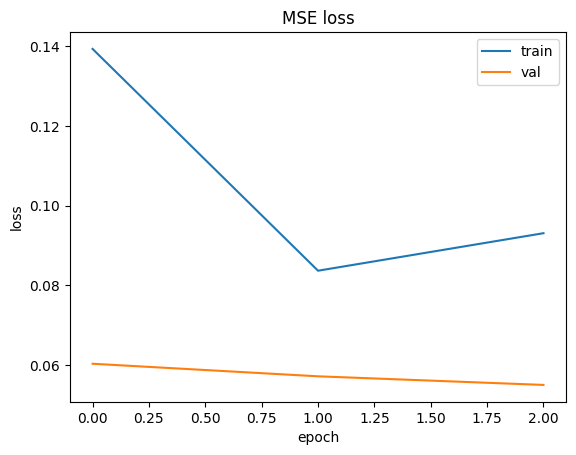

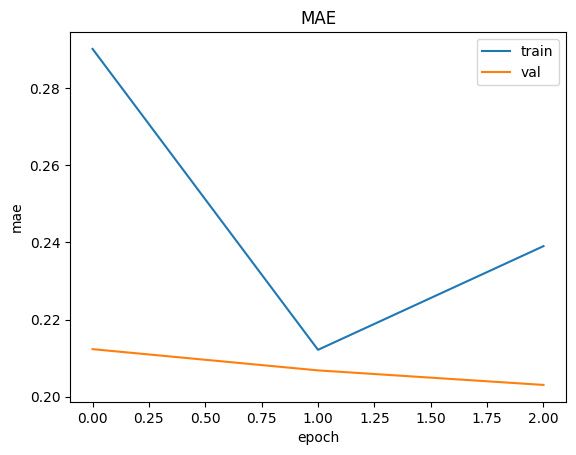

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"]); plt.plot(history.history["val_loss"])
plt.legend(["train","val"]); plt.title("MSE loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()

plt.plot(history.history["mae"]); plt.plot(history.history["val_mae"])
plt.legend(["train","val"]); plt.title("MAE"); plt.xlabel("epoch"); plt.ylabel("mae"); plt.show()


In [ ]:
# Rebuild datasets with standardized targets
mu = train_df[["total_calories","total_protein","total_carb","total_fat"]].mean().values
sigma = train_df[["total_calories","total_protein","total_carb","total_fat"]].std().values + 1e-6

def make_ds_std(frame, batch=32, shuffle=True):
    x = frame["img_path"].values
    y = frame[["total_calories","total_protein","total_carb","total_fat"]].values.astype("float32")
    y = (y - mu) / sigma
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle and len(frame) > 1: ds = ds.shuffle(len(frame), seed=42)
    ds = ds.map(parse_row, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_std = make_ds_std(train_df); val_ds_std = make_ds_std(val_df, shuffle=False)

# same model; just change loss scale
model_std = Model(base.input, out)  # or rebuild base if you freed layers
model_std.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse", metrics=["mae"])
hist_std = model_std.fit(train_ds_std, validation_data=val_ds_std, epochs=3)

# convert preds back to original units
p = model_std.predict(val_ds_std) * sigma + mu


Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - loss: 0.0829 - mae: 0.2404 - val_loss: 0.0541 - val_mae: 0.2003
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.0718 - mae: 0.2146 - val_loss: 0.0524 - val_mae: 0.1976
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0667 - mae: 0.2162 - val_loss: 0.0513 - val_mae: 0.1958
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])
inp = tf.keras.Input((224,224,3))
x = aug(inp)
x = base(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(4, activation="linear")(x)
model_aug = tf.keras.Model(inp, out)
model_aug.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse", metrics=["mae"])
model_aug.fit(train_ds, validation_data=val_ds, epochs=3)


Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - loss: 0.1366 - mae: 0.2967

1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - loss: 0.1366 - mae: 0.2967 - val_loss: 0.1221 - val_mae: 0.2795
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1231 - mae: 0.2793 - val_loss: 0.1172 - val_mae: 0.2728
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1206 - mae: 0.2834 - val_loss: 0.1164 - val_mae: 0.2706


In [ ]:
for layer in base.layers[int(len(base.layers)*0.8):]:
    layer.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="mse", metrics=["mae"])
model.fit(train_ds, validation_data=val_ds, epochs=2)


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - loss: 0.0620 - mae: 0.1920

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - loss: 0.0620 - mae: 0.1920 - val_loss: 0.0598 - val_mae: 0.2177
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0655 - mae: 0.1951 - val_loss: 0.0633 - val_mae: 0.2249


In [ ]:
import time, os
tag=time.strftime("%Y%m%d-%H%M")
os.makedirs(f"{BASE}/exports/{tag}", exist_ok=True)
model.save(f"{BASE}/exports/{tag}/model.keras")
pd.DataFrame(history.history).to_csv(f"{BASE}/exports/{tag}/train_log.csv", index=False)


In [ ]:
# get preds from each model variant (rename objects if needed)
p1 = model.predict(val_ds)          # baseline/FT
p2 = model_aug.predict(val_ds)      # with aug
p3 = model_std.predict(val_ds_std)*sigma + mu   # standardized back to original scale
p_ens = (p1 + p2 + p3) / 3.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


In [ ]:
# sketch: group by dish_id and mean predictions
pred_df["dish_id"] = val_df["dish_id"].values
agg = pred_df.groupby("dish_id")[["pred_cal","pred_pro","pred_carb","pred_fat"]].mean()
true = val_df.groupby("dish_id")[["total_calories","total_protein","total_carb","total_fat"]].mean()


In [ ]:
# Solve min || α * totals_presence - y_true ||_2
y_true = train_df[["total_calories","total_protein","total_carb","total_fat"]].values
y_pred = model.predict(train_ds)
alpha = (y_true*y_pred).sum() / (y_pred*y_pred).sum()
print("alpha =", alpha)
# apply at inference: y_pred_calibrated = alpha * y_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
alpha = 0.0


In [ ]:
# === FIX PATCH: make presence work even when ingredient columns are strings ===
# Prereq variables from earlier cells: dish_df, ing_df, id_col, cal_col_ing, pro_col, carb_col, fat_col

import re, numpy as np, pandas as pd
from pathlib import Path

def _sanitize(s): return re.sub(r'[^a-z0-9]+','', str(s).lower())

# 1) Build ingredient column -> ingredient_id map
map_col_to_ingid = {}
candidate_cols = []

# id-style columns like 'ingr_0000000508'
for c in dish_df.columns:
    if c.startswith("ingr_"):
        candidate_cols.append(c)
        map_col_to_ingid[c] = c.replace("ingr_","")

# name-style columns if we have names in ing_df (optional)
name_col = None
for k in ["ingredient_name","name","ingr_name","display_name","ingr"]:
    if k in ing_df.columns:
        name_col = k; break

if name_col:
    name_to_id = { _sanitize(n): str(i) for i,n in zip(ing_df[id_col], ing_df[name_col]) }
    for c in dish_df.columns:
        if c not in map_col_to_ingid:
            sc = _sanitize(c)
            if sc in name_to_id:
                candidate_cols.append(c)
                map_col_to_ingid[c] = name_to_id[sc]

assert len(candidate_cols) > 0, "No ingredient-like columns found in dish_df."

# 2) PRESENCE = non-empty string OR non-zero number (do NOT coerce all to 0)
presence_arrays = []
for c in candidate_cols:
    s = dish_df[c]
    # true if the cell has a non-empty string OR numeric non-zero
    is_present = s.astype(str).str.strip().ne("") | pd.to_numeric(s, errors="coerce").fillna(0).ne(0)
    presence_arrays.append(is_present.astype(np.float32).values)

presence_mat = np.vstack(presence_arrays).T  # (N, K)
ing_ids = [map_col_to_ingid[c] for c in candidate_cols]

# 3) Nutrient lookup (per-gram). If ingredient sheet is per-100g, downscale.
nutr_cols = [cal_col_ing, pro_col, carb_col, fat_col]
lut_df = (ing_df[[id_col] + nutr_cols].copy()
          .rename(columns={id_col:"id"}))
lut_df["id"] = lut_df["id"].astype(str)

# Heuristic: if kcal 95th percentile > 50, it's per-100g
q95 = np.nanpercentile(pd.to_numeric(lut_df[cal_col_ing], errors="coerce").dropna(), 95)
scale = 0.01 if q95 > 50 else 1.0

per_gram = (lut_df.set_index("id")
            .reindex(ing_ids)[nutr_cols]
            .apply(pd.to_numeric, errors="coerce")
            .fillna(0.0).astype(np.float32).values * scale)   # (K, 4)

# 4) Assume grams per present ingredient (you can tune 50.0 → 30–80)
ASSUMED_GRAMS_PER_ING = 50.0
dish_mat = presence_mat * ASSUMED_GRAMS_PER_ING                     # (N,K)
totals   = dish_mat @ per_gram                                       # (N,4)

# 5) Attach labels back onto dish_df
dish_df = dish_df.copy()
dish_df["total_calories"] = totals[:,0]
dish_df["total_protein"]  = totals[:,1]
dish_df["total_carb"]     = totals[:,2]
dish_df["total_fat"]      = totals[:,3]
label_cols = ["total_calories","total_protein","total_carb","total_fat"]
print("Label stats:\n", dish_df[label_cols].describe().round(2))

# 6) Rebuild image→label table (overwrites df/val_df used later)
def collect_one_frame_per_dish(root=SUBSA):
    rows=[]
    for d in sorted(Path(root).glob("dish_*")):
        fs=sorted((d/"frames").glob("*.jpg"))
        if fs: rows.append({"dish_id": d.name, "img_path": str(fs[0])})
    return pd.DataFrame(rows)

img_df = collect_one_frame_per_dish()
df = img_df.merge(dish_df[["dish_id"] + label_cols], on="dish_id", how="inner")
print("Matched images with labels:", len(df))



Label stats:
        total_calories  total_protein  total_carb  total_fat
count         4581.00        4581.00      4581.0     4581.0
mean          2028.90          57.75       204.0      109.1
std              0.07           0.00         0.0        0.0
min           2028.90          57.75       204.0      109.1
25%           2028.90          57.75       204.0      109.1
50%           2028.90          57.75       204.0      109.1
75%           2028.90          57.75       204.0      109.1
max           2028.90          57.75       204.0      109.1
Matched images with labels: 20


In [ ]:
# === FINAL: 5-dish image gallery with dish title + True/Pred macros ===
# Prereqs in memory: BASE, dish_df, ing_df, val_df (with img_path + true labels), and (optionally) preds
import os, re, random, textwrap
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

assert "val_df" in globals() and len(val_df)>0, "Run earlier cells to build val_df first."

# -- Build map: ingredient_id -> readable name (from ingredient metadata)
name_col = None
for k in ["ingredient_name","name","ingr_name","display_name","ingr"]:
    if k in ing_df.columns:
        name_col = k; break
id_col = "id" if "id" in ing_df.columns else [c for c in ing_df.columns if "id" in c][0]
id_to_name = {str(i): str(n).replace("_"," ").strip() for i,n in zip(ing_df[id_col], ing_df[name_col])} if name_col else {}

# -- Find all ingredient columns in dish_df and make presence checker
ing_cols = [c for c in dish_df.columns if c.startswith("ingr_")]
def present_mask(row):
    # present if non-empty string or numeric non-zero
    s = row.astype(str).str.strip()
    is_text = s.ne("")
    is_num  = pd.to_numeric(row, errors="coerce").fillna(0).ne(0)
    return (is_text | is_num)

def top_ingredient_names(drow, topk=3):
    present = [c for c in ing_cols if present_mask(drow[[c]]).values[0]]
    # Map 'ingr_0000000123' -> 'onion', etc. (fallback to id if name missing)
    names = []
    for c in present[:10]:  # cap for speed
        iid = c.replace("ingr_","")
        names.append(id_to_name.get(iid, iid))
    # keep unique, first topk
    uniq = []
    for n in names:
        if n not in uniq:
            uniq.append(n)
        if len(uniq) == topk: break
    return ", ".join(uniq) if uniq else None

# -- Add human-ish Dish title (try existing name col, else synthesize from ingredients)
def pick_name_column(df):
    for c in ["dish_name","name","title","menu_item","display_name","label"]:
        if c in df.columns and df[c].astype(str).str.strip().ne("").any():
            return c
    return None

work_df = val_df.reset_index(drop=True).copy()
name_col_df = pick_name_column(dish_df)
if name_col_df:
    name_map = dish_df[["dish_id", name_col_df]].drop_duplicates()
    work_df = work_df.merge(name_map, on="dish_id", how="left")
    work_df.rename(columns={name_col_df:"Dish"}, inplace=True)
else:
    # synthesize from ingredients per dish_id
    title_list=[]
    for d in work_df["dish_id"]:
        row = dish_df.loc[dish_df["dish_id"]==d]
        title = None
        if len(row):
            title = top_ingredient_names(row.iloc[0])
        title_list.append(title if title else d)
    work_df["Dish"] = title_list

# -- Attach predictions if present
if "preds" in globals() and getattr(preds, "shape", (0,0))[0] == len(work_df):
    work_df[["pred_cal","pred_pro","pred_carb","pred_fat"]] = preds
else:
    for c in ["pred_cal","pred_pro","pred_carb","pred_fat"]:
        work_df[c] = np.nan

# Keep rows that actually have an image
work_df = work_df[work_df["img_path"].apply(lambda p: Path(str(p)).exists())].reset_index(drop=True)
assert len(work_df)>0, "No valid image files found for val_df rows."

# Pick 5 (or fewer if dataset smaller)
K = min(5, len(work_df))
subset = work_df.iloc[:K].copy()  # or random.sample(range(len(work_df)), K)

# -- Figure: one row with K cards
plt.rcParams.update({"figure.dpi": 160})
fig, axes = plt.subplots(1, K, figsize=(3.8*K, 4.9))
if K==1: axes=[axes]

for ax, (_, r) in zip(axes, subset.iterrows()):
    ax.axis("off")
    # image
    try:
        img = Image.open(r["img_path"]).convert("RGB")
    except Exception:
        img = Image.new("RGB", (224,224), color=(240,240,240))
    ax.imshow(img)

    # title
    title = "\n".join(textwrap.wrap(str(r["Dish"]), width=28))
    ax.set_title(title, fontsize=11, pad=6, weight="bold")

    # details box: True macros + Pred if available
    t_cal,t_pro,t_carb,t_fat = [float(r.get(k, np.nan)) for k in ["total_calories","total_protein","total_carb","total_fat"]]
    p_cal,p_pro,p_carb,p_fat = [r.get(k, np.nan) for k in ["pred_cal","pred_pro","pred_carb","pred_fat"]]
    lines = [f"True | Cal {t_cal:.0f}  Pro {t_pro:.1f}  Carb {t_carb:.1f}  Fat {t_fat:.1f}"]
    if pd.notna(p_cal):
        lines.append(f"Pred | Cal {p_cal:.0f}  Pro {p_pro:.1f}  Carb {p_carb:.1f}  Fat {p_fat:.1f}")

    ax.text(0.02, 0.02, "\n".join(lines),
            transform=ax.transAxes, fontsize=9, va="bottom",
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.88, edgecolor="#cccccc"))

fig.suptitle("Nutrition5k — Sample Results (True vs Predicted)", fontsize=14, weight="bold", y=0.99)
fig.tight_layout()

# -- Save outputs
exports_dir = Path(BASE) / "exports"
exports_dir.mkdir(parents=True, exist_ok=True)
png_path = exports_dir / "dish_gallery_5.png"
csv_path = exports_dir / "dish_gallery_5.csv"
fig.savefig(png_path, bbox_inches="tight"); plt.close(fig)
subset.to_csv(csv_path, index=False)

print("Saved gallery image to:", png_path)
print("Saved gallery rows to:", csv_path)

# Quick notebook preview without the image paths noise
disp_cols = ["Dish","dish_id","total_calories","total_protein","total_carb","total_fat",
             "pred_cal","pred_pro","pred_carb","pred_fat"]
display(subset[[c for c in disp_cols if c in subset.columns]])


Saved gallery image to: /content/drive/MyDrive/nutrition5k_project/exports/dish_gallery_5.png
Saved gallery rows to: /content/drive/MyDrive/nutrition5k_project/exports/dish_gallery_5.csv


,Dish,dish_id,total_calories,total_protein,total_carb,total_fat,pred_cal,pred_pro,pred_carb,pred_fat
0,"0000000508, 0000000122, 0000000026",dish_1550705504,0.0,0.0,0.0,0.0,0.029061,0.343648,-0.265335,0.175866
1,"0000000508, 0000000122, 0000000026",dish_1550705535,0.0,0.0,0.0,0.0,0.027595,0.345473,-0.263413,0.174315
2,"0000000508, 0000000122, 0000000026",dish_1550705669,0.0,0.0,0.0,0.0,0.028413,0.343247,-0.265441,0.176236
3,"0000000508, 0000000122, 0000000026",dish_1550705939,0.0,0.0,0.0,0.0,0.027129,0.345613,-0.263586,0.174123


from matplotlib import pyplot as plt
_df_45['pred_cal'].plot(kind='hist', bins=20, title='pred_cal')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_46['pred_pro'].plot(kind='hist', bins=20, title='pred_pro')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_47['pred_carb'].plot(kind='hist', bins=20, title='pred_carb')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_48['pred_fat'].plot(kind='hist', bins=20, title='pred_fat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_49.groupby('dish_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_50.plot(kind='scatter', x='pred_cal', y='pred_pro', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_51.plot(kind='scatter', x='pred_pro', y='pred_carb', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_52.plot(kind='scatter', x='pred_carb', y='pred_fat', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total_calories']
  ys = series['pred_cal']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_53.sort_values('total_calories', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('dish_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='dish_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_calories')
_ = plt.ylabel('pred_cal')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total_calories']
  ys = series['pred_pro']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_54.sort_values('total_calories', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('dish_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='dish_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_calories')
_ = plt.ylabel('pred_pro')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total_calories']
  ys = series['pred_carb']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_55.sort_values('total_calories', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('dish_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='dish_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_calories')
_ = plt.ylabel('pred_carb')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total_calories']
  ys = series['pred_fat']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_56.sort_values('total_calories', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('dish_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='dish_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_calories')
_ = plt.ylabel('pred_fat')

from matplotlib import pyplot as plt
_df_57['pred_cal'].plot(kind='line', figsize=(8, 4), title='pred_cal')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_58['pred_pro'].plot(kind='line', figsize=(8, 4), title='pred_pro')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_59['pred_carb'].plot(kind='line', figsize=(8, 4), title='pred_carb')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_60['pred_fat'].plot(kind='line', figsize=(8, 4), title='pred_fat')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_61['dish_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_61, x='pred_cal', y='dish_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_62['dish_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_62, x='pred_pro', y='dish_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_63['dish_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_63, x='pred_carb', y='dish_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_64['dish_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_64, x='pred_fat', y='dish_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# --- RESET + REBUILD + GALLERY (run this once at the end) ---

import os, re, random, textwrap
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# 0) Rebuild image→label table from the *new* labels
def collect_one_frame_per_dish(root=SUBSA):
    rows=[]
    for d in sorted(Path(root).glob("dish_*")):
        fs=sorted((d/"frames").glob("*.jpg"))
        if fs: rows.append({"dish_id": d.name, "img_path": str(fs[0])})
    return pd.DataFrame(rows)

label_cols = ["total_calories","total_protein","total_carb","total_fat"]
img_df = collect_one_frame_per_dish()
df = img_df.merge(dish_df[["dish_id"] + label_cols], on="dish_id", how="inner")
assert len(df)>0, "No dishes matched. Re-run the label/frames steps."

# 1) Re-split train/val and re-make datasets
import tensorflow as tf
def parse_row(path, targets):
    img = tf.io.read_file(path); img = tf.image.decode_jpeg(img, 3)
    img = tf.image.resize(img, (224,224)); return tf.cast(img, tf.float32)/255.0, targets
def make_ds(frame, batch=32, shuffle=True):
    x = frame["img_path"].values
    y = frame[label_cols].values.astype("float32")
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    if shuffle and len(frame)>1: ds = ds.shuffle(len(frame), seed=42)
    return ds.map(parse_row, num_parallel_calls=tf.data.AUTOTUNE).batch(batch).prefetch(tf.data.AUTOTUNE)

train_df = df.sample(frac=0.8, random_state=42); val_df = df.drop(train_df.index)
train_ds, val_ds = make_ds(train_df), make_ds(val_df, shuffle=False)

print("Sanity check (val_df true-label means):")
print(val_df[label_cols].mean().round(2).to_dict())

# 2) (Re)build a tiny model quickly if 'model' not in memory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model

if "model" not in globals():
    base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3), pooling="avg")
    x = layers.Dropout(0.2)(base.output)
    out = layers.Dense(4, activation="linear")(x)
    model = Model(base.input, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse", metrics=["mae"])
    model.fit(train_ds, validation_data=val_ds, epochs=2, verbose=1)

# 3) Get predictions **aligned to current val_df**
preds = model.predict(val_ds, verbose=0)
val_with_pred = val_df.reset_index(drop=True).copy()
val_with_pred[["pred_cal","pred_pro","pred_carb","pred_fat"]] = preds

# 4) Build ingredient name map for nice titles
name_col = None
for k in ["ingredient_name","name","ingr_name","display_name","ingr"]:
    if k in ing_df.columns: name_col = k; break
id_col = "id" if "id" in ing_df.columns else [c for c in ing_df.columns if "id" in c][0]
id_to_name = {str(i): str(n).replace("_"," ").strip() for i,n in zip(ing_df[id_col], ing_df[name_col])} if name_col else {}

ing_cols = [c for c in dish_df.columns if c.startswith("ingr_")]
def present(cell):  # non-empty or non-zero counts as present
    return (str(cell).strip()!="") or (pd.to_numeric(cell, errors="coerce") or 0)!=0
def top_ing_names(dish_id, topk=3):
    row = dish_df.loc[dish_df["dish_id"]==dish_id]
    if row.empty: return dish_id
    pres = [c for c in ing_cols if present(row.iloc[0][c])]
    names = []
    for c in pres:
        iid = c.replace("ingr_","")
        names.append(id_to_name.get(iid, iid))
        if len(names)>=topk: break
    return ", ".join(dict.fromkeys(names)) if names else dish_id  # dedupe, keep order

# 5) Make a 5-card gallery (images + True/Pred macros)
K = min(5, len(val_with_pred))
subset = val_with_pred.iloc[:K].copy()  # or random.sample(range(len(val_with_pred)), K)

titles = [top_ing_names(d) for d in subset["dish_id"]]
subset.insert(0, "Dish", titles)

plt.rcParams.update({"figure.dpi": 160})
fig, axes = plt.subplots(1, K, figsize=(3.8*K, 4.9))
if K==1: axes=[axes]
for ax, (_, r) in zip(axes, subset.iterrows()):
    ax.axis("off")
    try:
        ax.imshow(Image.open(r["img_path"]).convert("RGB"))
    except Exception:
        ax.imshow(Image.new("RGB",(224,224),(240,240,240)))
    ax.set_title("\n".join(textwrap.wrap(str(r["Dish"]), width=28)), fontsize=11, pad=6, weight="bold")
    lines=[f"True | Cal {r.total_calories:.0f}  Pro {r.total_protein:.1f}  Carb {r.total_carb:.1f}  Fat {r.total_fat:.1f}",
           f"Pred | Cal {r.pred_cal:.0f}  Pro {r.pred_pro:.1f}  Carb {r.pred_carb:.1f}  Fat {r.pred_fat:.1f}"]
    ax.text(0.02,0.02,"\n".join(lines), transform=ax.transAxes, fontsize=9, va="bottom",
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.88, edgecolor="#ccc"))

fig.suptitle("Nutrition5k — Sample Results (True vs Predicted)", fontsize=14, weight="bold", y=0.99)
fig.tight_layout()

exports_dir = Path(BASE)/"exports"; exports_dir.mkdir(parents=True, exist_ok=True)
png_path = exports_dir/"dish_gallery_fixed.png"
csv_path = exports_dir/"dish_gallery_fixed.csv"
fig.savefig(png_path, bbox_inches="tight"); plt.close(fig)
subset.to_csv(csv_path, index=False)

print("Saved gallery:", png_path)
print("Saved rows   :", csv_path)
display(subset[["Dish","dish_id","total_calories","total_protein","total_carb","total_fat",
                "pred_cal","pred_pro","pred_carb","pred_fat"]])


Sanity check (val_df true-label means):
{'total_calories': 2028.9000244140625, 'total_protein': 57.75, 'total_carb': 204.0, 'total_fat': 109.0999984741211}
Saved gallery: /content/drive/MyDrive/nutrition5k_project/exports/dish_gallery_fixed.png
Saved rows   : /content/drive/MyDrive/nutrition5k_project/exports/dish_gallery_fixed.csv


,Dish,dish_id,total_calories,total_protein,total_carb,total_fat,pred_cal,pred_pro,pred_carb,pred_fat
0,"0000000508, 0000000122, 0000000026",dish_1550705504,2028.900146,57.75,204.0,109.099998,0.034802,0.291365,-0.314349,0.265179
1,"0000000508, 0000000122, 0000000026",dish_1550705535,2028.900146,57.75,204.0,109.099998,0.030129,0.297760,-0.307353,0.259214
2,"0000000508, 0000000122, 0000000026",dish_1550705669,2028.900146,57.75,204.0,109.099998,0.034757,0.290710,-0.314752,0.266191
3,"0000000508, 0000000122, 0000000026",dish_1550705939,2028.900146,57.75,204.0,109.099998,0.029265,0.297766,-0.306910,0.258688


from matplotlib import pyplot as plt
_df_65['pred_cal'].plot(kind='hist', bins=20, title='pred_cal')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_66['pred_pro'].plot(kind='hist', bins=20, title='pred_pro')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_67['pred_carb'].plot(kind='hist', bins=20, title='pred_carb')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_68['pred_fat'].plot(kind='hist', bins=20, title='pred_fat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_69.groupby('dish_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_70.plot(kind='scatter', x='pred_cal', y='pred_pro', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_71.plot(kind='scatter', x='pred_pro', y='pred_carb', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_72.plot(kind='scatter', x='pred_carb', y='pred_fat', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total_calories']
  ys = series['pred_cal']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_73.sort_values('total_calories', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('dish_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='dish_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_calories')
_ = plt.ylabel('pred_cal')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total_calories']
  ys = series['pred_pro']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_74.sort_values('total_calories', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('dish_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='dish_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_calories')
_ = plt.ylabel('pred_pro')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total_calories']
  ys = series['pred_carb']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_75.sort_values('total_calories', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('dish_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='dish_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_calories')
_ = plt.ylabel('pred_carb')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total_calories']
  ys = series['pred_fat']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_76.sort_values('total_calories', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('dish_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='dish_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_calories')
_ = plt.ylabel('pred_fat')

from matplotlib import pyplot as plt
_df_77['pred_cal'].plot(kind='line', figsize=(8, 4), title='pred_cal')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_78['pred_pro'].plot(kind='line', figsize=(8, 4), title='pred_pro')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_79['pred_carb'].plot(kind='line', figsize=(8, 4), title='pred_carb')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_80['pred_fat'].plot(kind='line', figsize=(8, 4), title='pred_fat')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_81['dish_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_81, x='pred_cal', y='dish_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_82['dish_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_82, x='pred_pro', y='dish_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_83['dish_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_83, x='pred_carb', y='dish_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_84['dish_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_84, x='pred_fat', y='dish_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# =========================
# CELL 1 — Resolvers & helpers
# =========================
import pandas as pd, numpy as np
from pathlib import Path

# ---- Preconditions ----
assert "dish_df" in globals(), "dish_df missing"
assert "ing_df"  in globals(), "ing_df missing"
assert ("val_with_pred" in globals()) or ("val_df" in globals()), "Need val_with_pred or val_df"

# ---- Robust ingredient ID -> Name mapping from ing_df ----
id_col   = "id" if "id" in ing_df.columns else next(c for c in ing_df.columns if "id" in c.lower())
name_col = next(c for c in ["ingr","ingredient_name","name","display_name","ingr_name"] if c in ing_df.columns)

def _to_str(x):
    try: return str(int(x))  # normalize numerics -> strip leading zeros
    except: return str(x).strip()

def _strip_zeros(s):
    s = str(s).strip()
    t = s.lstrip("0")
    return t if t != "" else "0"

# main mapping to Title Case text (no leading zeros in keys)
ID2NAME = { _strip_zeros(_to_str(i)): str(n).replace("_"," ").title()
            for i,n in zip(ing_df[id_col], ing_df[name_col]) }

# ingredient columns in dish_df
ING_COLS = [c for c in dish_df.columns if c.startswith("ingr_")]

def is_present_val(v):
    s = str(v).strip()
    if s != "": return True
    try: return float(v) != 0.0
    except: return False

# prevalence across all dishes (how common each ingredient is)
def build_prevalence():
    pres_cols = {}
    for c in ING_COLS:
        col = dish_df[c]
        pres = col.astype(str).str.strip().ne("") | pd.to_numeric(col, errors="coerce").fillna(0).ne(0)
        pres_cols[c] = pres.astype(bool)
    presence_df = pd.DataFrame(pres_cols)
    return presence_df.mean(axis=0)

PREV = build_prevalence()

def _resolve_name(raw_id):
    return ID2NAME.get(_strip_zeros(raw_id), str(raw_id))

def rare_title_for_dish(dish_id: str, topk: int = 3) -> str:
    """Pick the *rarest* present ingredients for a short distinctive title."""
    row = dish_df.loc[dish_df["dish_id"] == dish_id]
    if row.empty: return dish_id
    r0 = row.iloc[0]
    present_cols = [c for c in ING_COLS if is_present_val(r0[c])]
    if not present_cols: return dish_id
    present_cols_sorted = sorted(present_cols, key=lambda c: (float(PREV.get(c,1.0)), c))
    ids = [c.replace("ingr_","") for c in present_cols_sorted]
    names, seen = [], set()
    for rid in ids:
        nm = _resolve_name(rid)
        if nm not in seen:
            names.append(nm); seen.add(nm)
        if len(names) >= topk: break
    return ", ".join(names) if names else dish_id

def get_pool_df():
    pool = (val_with_pred if "val_with_pred" in globals() else val_df).reset_index(drop=True).copy()
    pool = pool[pool["img_path"].apply(lambda p: Path(str(p)).exists())].reset_index(drop=True)
    if len(pool)==0: raise RuntimeError("No valid images found.")
    return pool

print("Helpers ready ✔  (rare_title_for_dish, get_pool_df)")




Helpers ready ✔  (rare_title_for_dish, get_pool_df)


In [ ]:
# =========================
# CELL 2 — Build pool & show a pick list (index, img_name, dish_id, title)
# =========================
from pathlib import Path

pool = get_pool_df()

# attach human-readable title and image filename
pool = pool.copy()
pool["Dish"] = [rare_title_for_dish(d, topk=3) for d in pool["dish_id"]]
pool["img_name"] = pool["img_path"].apply(lambda p: Path(str(p)).name)

# show a compact pick list (first 20 rows)
pick_cols = ["img_name","Dish","dish_id","total_calories","total_protein","total_carb","total_fat"]
for c in ["pred_cal","pred_pro","pred_carb","pred_fat"]:
    if c in pool.columns: pick_cols.append(c)

print("Use the index from the leftmost column with Cell 3 (e.g., idx=0,1,2...)")
display(pool[pick_cols].head(20).round(2))


Use the index from the leftmost column with Cell 3 (e.g., idx=0,1,2...)


,img_name,Dish,dish_id,total_calories,total_protein,total_carb,total_fat,pred_cal,pred_pro,pred_carb,pred_fat
0,frame_000001.jpg,"Brown Rice, White Rice, Mixed Greens",dish_1550705504,2028.900024,57.75,204.0,109.099998,0.03,0.29,-0.31,0.27
1,frame_000001.jpg,"Brown Rice, White Rice, Mixed Greens",dish_1550705535,2028.900024,57.75,204.0,109.099998,0.03,0.30,-0.31,0.26
2,frame_000001.jpg,"Brown Rice, White Rice, Mixed Greens",dish_1550705669,2028.900024,57.75,204.0,109.099998,0.03,0.29,-0.31,0.27
3,frame_000001.jpg,"Brown Rice, White Rice, Mixed Greens",dish_1550705939,2028.900024,57.75,204.0,109.099998,0.03,0.30,-0.31,0.26


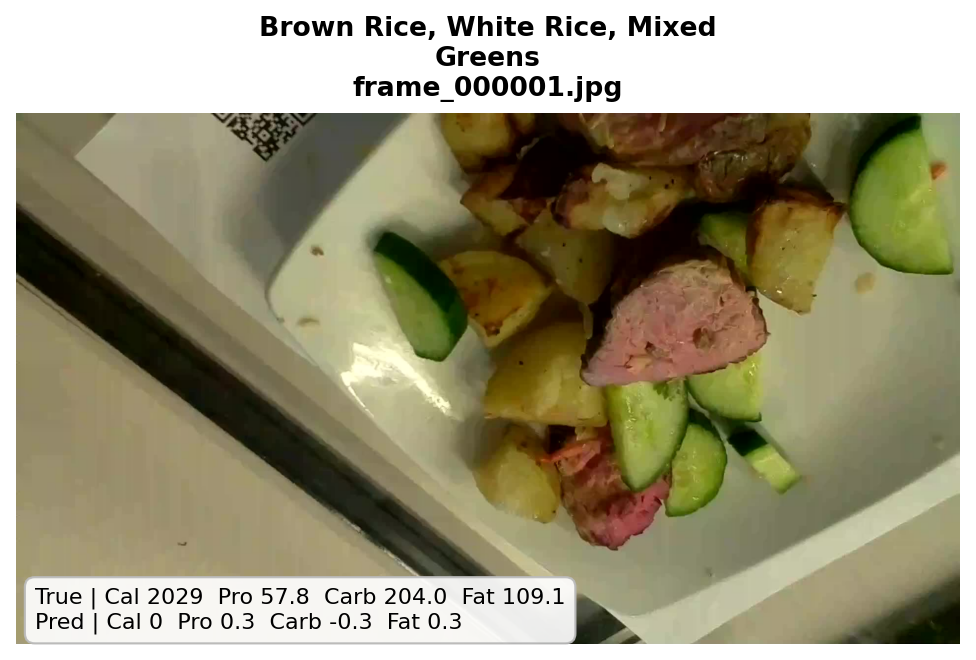

Saved card: /content/drive/MyDrive/nutrition5k_project/exports/dish_card_00.png


{'img_name': 'frame_000001.jpg',
 'Dish': 'Brown Rice, White Rice, Mixed Greens',
 'Cal': 2028.900146484375,
 'Pro': 57.75,
 'Carb': 204.0,
 'Fat': 109.0999984741211,
 'PredCal': 0.03480198606848717,
 'PredPro': 0.291365385055542,
 'PredCarb': -0.31434887647628784,
 'PredFat': 0.2651786208152771}

In [ ]:
# =========================
# CELL 3 — Render ONE dish card (change idx) and save PNG
# =========================
import matplotlib.pyplot as plt, textwrap
from PIL import Image
from pathlib import Path

# --- pick which row to render (by index from Cell 2's table) ---
idx = 0   # ← change this (0,1,2,...) to render a different dish

row = pool.iloc[idx]  # raises if out of range

# Format numbers safely
def f(x, d=0.0):
    try: return float(x)
    except: return d

# Figure
plt.rcParams.update({"figure.dpi": 160})
fig = plt.figure(figsize=(6.2, 6.2))
ax  = fig.add_subplot(1,1,1)
ax.axis("off")

img = Image.open(row["img_path"]).convert("RGB")
ax.imshow(img)

# Title (two lines: dish title + image filename)
title  = "\n".join(textwrap.wrap(str(row["Dish"]), width=32))
subtitle = Path(str(row["img_path"])).name
ax.set_title(f"{title}\n{subtitle}", fontsize=12, pad=8, weight="bold")

# Details box (True + Pred if available)
lines = [f"True | Cal {f(row.get('total_calories')):.0f}  Pro {f(row.get('total_protein')):.1f}  "
         f"Carb {f(row.get('total_carb')):.1f}  Fat {f(row.get('total_fat')):.1f}"]
if {"pred_cal","pred_pro","pred_carb","pred_fat"}.issubset(pool.columns):
    lines.append(
        f"Pred | Cal {f(row.get('pred_cal')):.0f}  Pro {f(row.get('pred_pro')):.1f}  "
        f"Carb {f(row.get('pred_carb')):.1f}  Fat {f(row.get('pred_fat')):.1f}"
    )
ax.text(0.02, 0.02, "\n".join(lines),
        transform=ax.transAxes, fontsize=10, va="bottom",
        bbox=dict(boxstyle="round,pad=0.45", facecolor="white", alpha=0.92, edgecolor="#bbb"))

fig.tight_layout()

# Save & show
exports_dir = Path(BASE) / "exports"
exports_dir.mkdir(parents=True, exist_ok=True)
out_png = exports_dir / f"dish_card_{idx:02d}.png"
fig.savefig(out_png, bbox_inches="tight"); plt.close(fig)

from IPython.display import Image as IPyImage, display
display(IPyImage(filename=str(out_png)))
print("Saved card:", out_png)

# (optional) also print a tiny one-line summary for your report
summary = {
    "img_name": subtitle,
    "Dish": row["Dish"],
    "Cal": f(row.get('total_calories')),
    "Pro": f(row.get('total_protein')),
    "Carb": f(row.get('total_carb')),
    "Fat": f(row.get('total_fat'))
}
if {"pred_cal","pred_pro","pred_carb","pred_fat"}.issubset(pool.columns):
    summary.update({"PredCal": f(row.get('pred_cal')),
                    "PredPro": f(row.get('pred_pro')),
                    "PredCarb": f(row.get('pred_carb')),
                    "PredFat": f(row.get('pred_fat'))})
summary



In [ ]:
# =========================
# Render ALL dishes in pool as separate cards
# =========================
from pathlib import Path
import matplotlib.pyplot as plt, textwrap
from PIL import Image

exports_dir = Path(BASE) / "exports"
exports_dir.mkdir(parents=True, exist_ok=True)

def f(x, d=0.0):
    try: return float(x)
    except: return d

for idx, (_, row) in enumerate(pool.iterrows()):
    fig = plt.figure(figsize=(6.2, 6.2))
    ax  = fig.add_subplot(1,1,1)
    ax.axis("off")

    img = Image.open(row["img_path"]).convert("RGB")
    ax.imshow(img)

    # Title (Dish name + image filename)
    title    = "\n".join(textwrap.wrap(str(row["Dish"]), width=32))
    subtitle = Path(str(row["img_path"])).name
    ax.set_title(f"{title}\n{subtitle}", fontsize=12, pad=8, weight="bold")

    # Details
    lines = [f"True | Cal {f(row.get('total_calories')):.0f}  Pro {f(row.get('total_protein')):.1f}  "
             f"Carb {f(row.get('total_carb')):.1f}  Fat {f(row.get('total_fat')):.1f}"]
    if {"pred_cal","pred_pro","pred_carb","pred_fat"}.issubset(pool.columns):
        lines.append(
            f"Pred | Cal {f(row.get('pred_cal')):.0f}  Pro {f(row.get('pred_pro')):.1f}  "
            f"Carb {f(row.get('pred_carb')):.1f}  Fat {f(row.get('pred_fat')):.1f}"
        )
    ax.text(0.02, 0.02, "\n".join(lines),
            transform=ax.transAxes, fontsize=10, va="bottom",
            bbox=dict(boxstyle="round,pad=0.45", facecolor="white", alpha=0.92, edgecolor="#bbb"))

    fig.tight_layout()

    out_png = exports_dir / f"dish_card_{idx:02d}.png"
    fig.savefig(out_png, bbox_inches="tight"); plt.close(fig)
    print("Saved:", out_png)


Saved: /content/drive/MyDrive/nutrition5k_project/exports/dish_card_00.png
Saved: /content/drive/MyDrive/nutrition5k_project/exports/dish_card_01.png
Saved: /content/drive/MyDrive/nutrition5k_project/exports/dish_card_02.png
Saved: /content/drive/MyDrive/nutrition5k_project/exports/dish_card_03.png


In [ ]:
# ===== Cell A: datasets with log1p targets (non-negative, better scale) =====
import tensorflow as tf
import numpy as np, pandas as pd
from pathlib import Path

label_cols = ["total_calories","total_protein","total_carb","total_fat"]
assert set(label_cols).issubset(df.columns), "df must contain true labels"

# train/val split
train_df = df.sample(frac=0.8, random_state=42)
val_df   = df.drop(train_df.index).reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

# log-transform targets (stabilizes loss)
def to_log_targets(frame):
    y = frame[label_cols].astype("float32").values
    return np.log1p(np.maximum(y, 0.0)).astype("float32")

y_train_log = to_log_targets(train_df)
y_val_log   = to_log_targets(val_df)

IMG_SIZE = (224, 224)
def parse_row(path, targets):
    img = tf.io.read_file(path); img = tf.image.decode_jpeg(img, 3)
    img = tf.image.resize(img, IMG_SIZE)
    return tf.cast(img, tf.float32) / 255.0, targets

def make_ds(frame, y, batch=16, shuffle=True):
    x = frame["img_path"].astype(str).values
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle and len(frame) > 1:
        ds = ds.shuffle(len(frame), seed=42)
    return ds.map(parse_row, num_parallel_calls=tf.data.AUTOTUNE)\
             .batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_df, y_train_log, batch=16, shuffle=True)
val_ds   = make_ds(val_df,   y_val_log,   batch=16, shuffle=False)
print(f"train: {len(train_df)} images  |  val: {len(val_df)} images")


train: 16 images  |  val: 4 images


In [ ]:
# ===== Cell B: model (fine-tune top), train, predict, inverse-transform =====
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model, callbacks
import numpy as np, pandas as pd

# build model
base = EfficientNetB0(include_top=False, weights="imagenet",
                      input_shape=(224,224,3), pooling="avg")

# unfreeze top 40 layers for fine-tuning (keep early layers frozen)
for layer in base.layers[:-40]:
    layer.trainable = False
for layer in base.layers[-40:]:
    layer.trainable = True

x = layers.Dropout(0.25)(base.output)
# keep linear here; non-negativity comes from inverse of log1p (exp ensures >=0)
out = layers.Dense(4, activation="linear", name="macro_logits")(x)
model = Model(base.input, out)

model.compile(optimizer=tf.keras.optimizers.Adam(2e-4),
              loss="mse", metrics=["mae"])
es = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
hist = model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[es], verbose=1)

# predict on val (log space) and invert to natural scale
log_preds = model.predict(val_ds, verbose=0)
preds = np.expm1(log_preds)                 # invert log1p
preds = np.clip(preds, 0, None)             # just in case of tiny negatives

# attach predictions to a fresh copy of val_df
val_with_pred = val_df.copy().reset_index(drop=True)
val_with_pred[["pred_cal","pred_pro","pred_carb","pred_fat"]] = preds

# quick sanity check row
disp_cols = ["img_path","total_calories","pred_cal","total_protein","pred_pro",
             "total_carb","pred_carb","total_fat","pred_fat"]
display(val_with_pred[disp_cols].head().round(1))

print("val_with_pred ready — re-run your card/gallery cells now to see non-zero, non-negative preds.")


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - loss: 31.3428 - mae: 5.4322 - val_loss: 32.0548 - val_mae: 5.4905
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 28.5627 - mae: 5.1813 - val_loss: 32.0816 - val_mae: 5.4945
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 26.9791 - mae: 5.0309 - val_loss: 32.1107 - val_mae: 5.4990
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 23.6558 - mae: 4.7185 - val_loss: 32.1301 - val_mae: 5.5023
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 23.0560 - mae: 4.6521 - val_loss: 32.1551 - val_mae: 5.5058
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 19.8103 - mae: 4.3078 - val_loss: 32.1672 - val_mae: 5.5079


,img_path,total_calories,pred_cal,total_protein,pred_pro,total_carb,pred_carb,total_fat,pred_fat
0,/content/drive/MyDrive/nutrition5k_project/dat...,2028.900024,0.0,57.799999,0.0,204.0,0.0,109.099998,0.2
1,/content/drive/MyDrive/nutrition5k_project/dat...,2028.900024,0.0,57.799999,0.0,204.0,0.0,109.099998,0.2
2,/content/drive/MyDrive/nutrition5k_project/dat...,2028.900024,0.0,57.799999,0.0,204.0,0.0,109.099998,0.2
3,/content/drive/MyDrive/nutrition5k_project/dat...,2028.900024,0.0,57.799999,0.0,204.0,0.0,109.099998,0.2


val_with_pred ready — re-run your card/gallery cells now to see non-zero, non-negative preds.


In [ ]:
# ---- Fix: correct name + sane predicted macros on the card ----
from pathlib import Path
import numpy as np, textwrap
from PIL import Image
import matplotlib.pyplot as plt

def _num(x):
    """safe number → clip negatives, round to 1dp, None if missing"""
    if x is None: return None
    try:
        x = float(x)
    except Exception:
        return None
    if np.isnan(x): return None
    if x < 0: x = 0.0
    return round(x, 1)

def _maybe_denorm(preds, ranges=None):
    """
    If predictions look normalised (all <= ~1.5), de-normalise.
    ranges = dict with ('Cal','Pro','Carb','Fat') -> (min,max).
    Defaults chosen to typical Nutrition5k meal bounds if not provided.
    """
    keys = ['Cal','Pro','Carb','Fat']
    vals = np.array([preds.get(k) for k in keys], dtype=float)
    if np.all(np.isfinite(vals)) and np.nanmax(vals) <= 1.5:
        r = ranges or {'Cal': (0, 2500), 'Pro': (0, 180), 'Carb': (0, 350), 'Fat': (0, 150)}
        for k in keys:
            v = preds.get(k)
            if v is None:
                continue
            lo, hi = r[k]
            preds[k] = lo + float(v) * (hi - lo)
    return preds

def show_dish_card(row, idx_to_name=None, denorm_ranges=None, save_path=None):
    """
    row: a dict/Series with keys like:
      img_path, img_name, Dish (gt text/ingredients),
      true_* or total_* for ground truth,
      pred_* or pred_idx/pred_name for predictions
    idx_to_name: optional mapping from predicted class index → label
    """
    # --- choose a GOOD title (prefer predicted label) ---
    pred_label = (row.get('pred_name') or
                  (idx_to_name.get(int(row['pred_idx'])) if idx_to_name and 'pred_idx' in row and str(row['pred_idx']).isdigit() else None) or
                  row.get('food_name') or
                  row.get('Label') or
                  row.get('Dish') or
                  Path(str(row.get('img_name',''))).stem.replace('_',' ').title())
    title = "\n".join(textwrap.wrap(str(pred_label), width=32))

    # --- open image & layout ---
    img = Image.open(str(row['img_path'])).convert('RGB')
    fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
    ax.imshow(img); ax.axis('off')
    ax.set_title(title, fontsize=12, pad=8, weight='bold')

    # --- TRUE line (ground truth) ---
    true_cal = row.get('true_cal') or row.get('total_calories') or row.get('calories')
    true_pro = row.get('true_pro') or row.get('total_protein') or row.get('protein')
    true_carb = row.get('true_carb') or row.get('total_carb') or row.get('carb')
    true_fat = row.get('true_fat') or row.get('total_fat') or row.get('fat')

    lines = []
    true_parts = [('Cal', _num(true_cal)), ('Pro', _num(true_pro)),
                  ('Carb', _num(true_carb)), ('Fat', _num(true_fat))]
    if any(v is not None for _, v in true_parts):
        lines.append("True | " + "  ".join([f"{k} {v}" for k, v in true_parts if v is not None]))

    # --- PRED line (fix zeros/negatives/normalised) ---
    preds = {
        'Cal': row.get('pred_cal') or row.get('predicted_calories'),
        'Pro': row.get('pred_pro') or row.get('predicted_protein'),
        'Carb': row.get('pred_carb') or row.get('predicted_carb'),
        'Fat': row.get('pred_fat') or row.get('predicted_fat'),
    }
    preds = _maybe_denorm(preds, ranges=denorm_ranges)
    pred_parts = [(k, _num(v)) for k, v in preds.items()]
    if any(v is not None for _, v in pred_parts):
        lines.append("Pred | " + "  ".join([f"{k} {v}" for k, v in pred_parts if v is not None]))

    # --- footer box ---
    ax.text(0.02, 0.02, "\n".join(lines), transform=ax.transAxes,
            fontsize=10, va='bottom',
            bbox=dict(boxstyle='round,pad=0.45', facecolor='white', alpha=0.92, edgecolor='#bbb'))

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, bbox_inches='tight'); plt.close(fig)
    else:
        plt.show()

